# Fig2: Stochastic Collapse into sign invriant set in a single-neuron model
Feng Chen, Daniel Kunin, Atsushi Yamamura, Surya Ganguli

In [1]:
using PyPlot
using Statistics
using LinearAlgebra
using LaTeXStrings
using Random
using DifferentialEquations
using DifferentialEquations.EnsembleAnalysis
using ProgressBars
using JLD2

## configurations

In [2]:
m = 32 #number of data points
noise_level = 0.1 # noise on Y for given X
T = 1000 # final time
tsteps = LinRange(0.0,T,100)
dt = 1e-2 # "time" step size
init_std = 0.001 # standard deviation for the random intialization of weights
zeta = 1.0
n_sample = 1000 # sample of trajectories
#activation function
σ(x) = tanh(x)
dσ(x) = 1 - (tanh(x))^2 # derivative

dσ (generic function with 1 method)

## generate data

In [3]:
X = randn(m)
Y = X + noise_level * randn(m)
XY2XX = sum(X .* Y) / sum(X.^2)

0.9847078901913183

In [9]:
function solve_single_scalar_neuron(eta::Float64, dt::Float64)
    sqrt_eta_zeta = sqrt(eta) * zeta
    Ŷ = zeros(m) # allocate memory outside here
    # drift
    function f(dw, w, p, t)
        Ŷ .= w[2] .* σ.(w[1] * X)
        dw[1] = -sum((Ŷ - Y) .* w[2] .* dσ.(w[1] * X) .* X) / m
        dw[2] = -sum((Ŷ - Y) .* σ.(w[1] * X)) / m
    end
    #diffusion
    function g(dw, w, p, t)
        dw[1,:] .= p[1] * w[2] .* dσ.(w[1] * X) .* X ./ sqrt(m) #p[1] = sqrt_eta_zeta
        dw[2,:] = p[1] * σ.(w[1] * X) ./ sqrt(m)
    end

    prob = SDEProblem(f, g, [0.0,0.0], (0.0, T), [sqrt_eta_zeta], noise_rate_prototype = zeros(2, m));
    # randomizing initlization for each trajectory
    function prob_func(prob, i, repeat)
        remake(prob, u0 = init_std * randn(2))
    end
    
    ensembleprob = EnsembleProblem(prob, prob_func = prob_func)
    sol = solve(ensembleprob, EM(), dt = dt, EnsembleThreads(), trajectories = n_sample);
    return sol
end

solve_single_scalar_neuron (generic function with 1 method)

## Compute the training trajectories for each noise level

In [10]:
list_eta = vcat(LinRange(0.0, 1.0, 5), LinRange(1.05, 2.5, 40), LinRange(2.6, 4.0, 5))
sols = [solve_single_scalar_neuron(eta, dt) for eta in ProgressBar(list_eta)];

0.0%┣                                              ┫ 0/50 [00:02<-1:-31, -2s/it]
2.0%┣▉                                          ┫ 1/50 [08:18<Inf:Inf, InfGs/it]
4.0%┣█▊                                        ┫ 2/50 [17:21<13:52:43, 1.0ks/it]
6.0%┣██▋                                        ┫ 3/50 [26:51<10:30:54, 805s/it]
8.0%┣███▍                                       ┫ 4/50 [36:08<09:14:05, 723s/it]
10.0%┣████▏                                     ┫ 5/50 [47:03<08:49:13, 706s/it]
12.0%┣█████                                     ┫ 6/50 [58:41<08:36:23, 704s/it]
14.0%┣█████▌                                 ┫ 7/50 [01:09:38<08:19:01, 696s/it]
16.0%┣██████▎                                ┫ 8/50 [01:20:27<08:02:44, 690s/it]
18.0%┣███████                                ┫ 9/50 [01:31:05<07:46:46, 683s/it]
20.0%┣███████▋                              ┫ 10/50 [01:42:20<07:34:51, 682s/it]
22.0%┣████████▍                             ┫ 11/50 [01:56:31<07:34:25, 699s/it]
24.0%┣█████████▏            

## save and load data

In [ ]:
traj_w = zeros(length(list_eta), 100, n_sample, 2)
for j in eachindex(list_eta)
    for i in eachindex(tsteps)
        traj_w[j,i,:,1] .= componentwise_vectors_timepoint(sols[j], tsteps[i])[1]
        traj_w[j,i,:,2] .= componentwise_vectors_timepoint(sols[j], tsteps[i])[2]
    end
end

filename = "sols-single-scalar-neuron.jld2"
jldopen(filename, "w") do file
    file["list_eta"] = list_eta
    file["traj_w"] = traj_w
    file["X"] = X
    file["Y"] = Y;
end

In [3]:
# loading data
filename = "sols-single-scalar-neuron.jld2"
f = load(filename);
XY2XX = sum(f["X"] .* f["Y"]) / sum(f["X"].^2)

0.9847078901913183

## generate figure:

In [4]:
thr = 1e-2
α = zeros(length(f["list_eta"]))
probability= zeros(length(tsteps), length(f["list_eta"]))
P12 = zeros(100)

for (j,eta) in enumerate(f["list_eta"])
    α[j] =  eta * zeta^2 * dσ(0.0) / 2
    for (i, t) in enumerate(tsteps)
        W1 = f["traj_w"][j, i, :, 1]
        W2 = f["traj_w"][j, i, :, 2]
        probability[i,j] = mean(sqrt.(W1.^2 .+ W2.^2) .< thr)
    end
end

In [5]:
# this configures the style of plots
function style_axes(ax, numyticks=5, numxticks=5, xlabel=false, ylabel=false)
    ax.tick_params(axis="y", which="both", bottom=true, top=false,
                   labelbottom=true, left=true, right=false,
                   labelleft=true,direction="out",length=7,width=1.5,pad=8,labelsize=24)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    
    ax.tick_params(axis="x", which="both", bottom=true, top=false,
                   labelbottom=true, left=true, right=false,
                   labelleft=true,direction="out",length=7,width=1.5,pad=8,
                   labelsize=24)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=true)
    #ax.ticklabel_format(axis="x", useMathText=true)
    ax.xaxis.offsetText.set_fontsize(20)
    ax.yaxis.offsetText.set_fontsize(20)
    
    if xlabel
        ax.set_xlabel(xlabel, fontsize=20)
    end
    if ylabel
        ax.set_ylabel(ylabel, fontsize=20)
    end
    
    # boundary
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false) 
    for dir in ["top", "bottom", "right", "left"]
        ax.spines[dir].set_linewidth(3)
    end
end

style_axes (generic function with 5 methods)

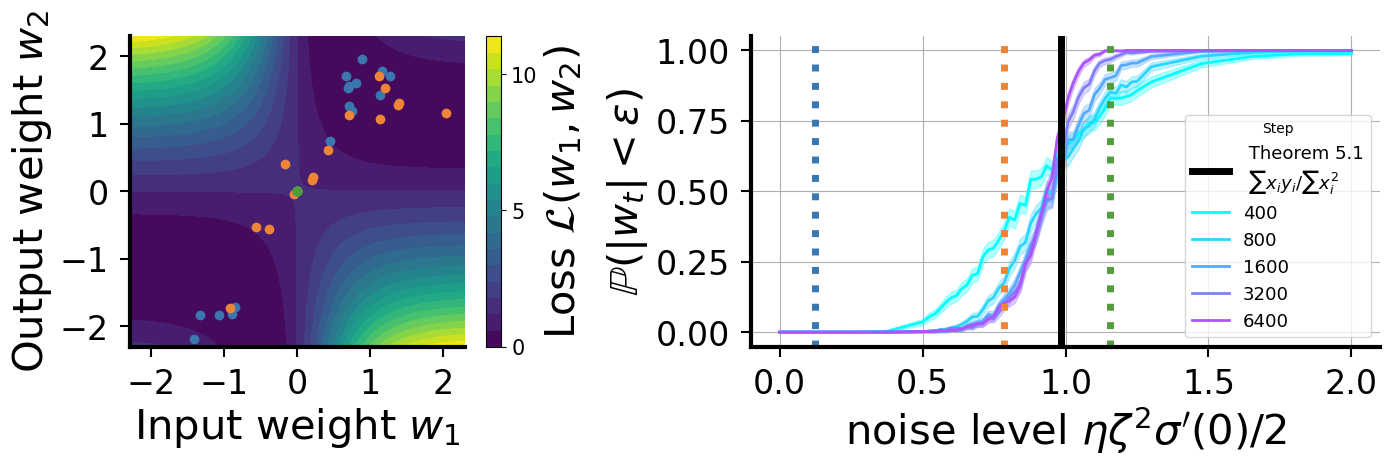

In [6]:
# Set up the figure and axes
nrows, ncols = 1, 2
fig, axes = subplots(nrows, ncols, figsize=(7 * ncols, 4.5 * nrows), gridspec_kw=Dict("width_ratios"=> [1, 1.5]))
cmap = plt.get_cmap("tab10")

# compute the energy landscape for heatmap
xy_range = 2.3
x = -xy_range:0.1:xy_range
y = -xy_range:0.1:xy_range
z = x' .+ im*y
U = (imag.(z) .* σ.(real.(z) * f["X"][1]) .- f["Y"][1]).^2

#figure1
style_axes(axes[1])
#heat map
contf = axes[1].contourf(x,y, U, levels=21)
cb = fig.colorbar(contf, ax=axes[1], ticks=[0,5,10])
cb.ax.tick_params(labelsize = 15)
cb.set_label(label=string("Loss ",L"\mathcal{L}(w_1,w_2)"), fontsize=30)

#scatter plot
points = 10:25
indexes = [2,20,40]
axes[1].scatter(f["traj_w"][indexes[1], end, points, 1], f["traj_w"][indexes[1], end, points, 2], color = "#3977AF")
axes[1].scatter(f["traj_w"][indexes[2], end, points, 1], f["traj_w"][indexes[2], end, points, 2], color = "#EE8435")
axes[1].scatter(f["traj_w"][indexes[3], end, points, 1], f["traj_w"][indexes[3], end, points, 2], color = "#529C3E")

axes[1].set_xlabel(string("Input weight " ,L"w_1"), fontsize=30)
axes[1].set_ylabel(string("Output weight " ,L"w_2"), fontsize=30)

# figure2
style_axes(axes[2])
axes[2].grid(true)
axes[2].set_xlabel(string("noise level ", L"\eta\zeta^2\sigma'(0)/2"), fontsize=30)
axes[2].set_ylabel(L"\mathbb{P}(\|w_t\|<\epsilon)", fontsize=30)
time_sweep = [4, 8, 16, 32, 64]
cmap = plt.get_cmap("cool")
#theory line
axes[2].axvline(x=XY2XX, c="k", lw=5, zorder=1000, label=string(" Theorem 5.1\n ",L"\sum x_iy_i/\sum x_i^2"))
for i in 1:length(time_sweep)
    color = cmap((i-1)/6)
    axes[2].plot(α ,probability[time_sweep[i],:], c=color, lw=2, label=Int(time_sweep[i]/dt))
    std = sqrt.(probability[time_sweep[i],:].*(1 .- probability[time_sweep[i],:])/256)
    axes[2].fill_between(α ,probability[time_sweep[i],:]-std,probability[time_sweep[i],:]+std,color=color, alpha=0.3)
end

# lines coresponding to scatter plots in the left panel
α_val(ind) = f["list_eta"][indexes[ind]] * zeta^2 / 2
axes[2].axvline(x=α_val(1), color = "#3977AF", lw=5, ls=":")#"small noise
axes[2].axvline(x=α_val(2), color = "#EE8435", lw=5, ls=":")#""medium noise"
axes[2].axvline(x=α_val(3), color = "#529C3E", lw=5, ls=":")#""large noise"

axes[2].legend(title="Step", loc="lower right", fontsize=13)
# Save figure
plt.tight_layout()